In [1]:
# -*- coding: utf-8 -*-
# slr_merge_screen.py
import pandas as pd
import numpy as np
from datetime import datetime

# ========= INPUTS =========
SCOPUS_FILE = "2108_Scopus Results_August 2025.xlsx"
WOS_FILE    = "2508_WoS Results_August 2025.xlsx"
YEAR_MIN, YEAR_MAX = 0, 2025

STAMP = datetime.now().strftime("%Y%m%d_%H%M")
OUTPUT_XLSX = f"SLR_WoS_Scopus_{STAMP}.xlsx"

# ========= COLUMN MAPS =========
SCOPUS_COL_MAP = {
    "Title": "Title",
    "Authors": "Authors",
    "Year": "Year",
    "Source title": "Source title",
    "Cited by": "Cited by",
    "DOI": "DOI",
    "Link": "Link",
    "Abstract": "Abstract",
    "Author Keywords": "Author Keywords",
    "Index Keywords": "Index Keywords",
    "Document Type": "Document Type",
}
WOS_COL_MAP = {
    "Article Title": "Title",
    "Authors": "Authors",
    "Publication Year": "Year",
    "Source Title": "Source title",
    "Times Cited, All Databases": "Cited by",
    "DOI": "DOI",
    "DOI Link": "Link",
    "Abstract": "Abstract",
    "Author Keywords": "Author Keywords",
    "Keywords Plus": "Index Keywords",
    "Document Type": "Document Type",
}

EXPECTED_COLS = [
    "Title","Authors","Year","Source title","Cited by","DOI","Link",
    "Abstract","Author Keywords","Index Keywords","Keywords","Database","Document Type"
]

def _ensure_columns(df, expected):
    for c in expected:
        if c not in df.columns:
            df[c] = ""
    return df[expected].copy()

# ========= LOADERS =========
def load_scopus(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, engine="openpyxl")
    df = df.rename(columns=SCOPUS_COL_MAP)

    ak = df.get("Author Keywords", pd.Series("", index=df.index)).fillna("")
    ik = df.get("Index Keywords", pd.Series("", index=df.index)).fillna("")
    df["Keywords"] = (ak + "; " + ik).str.strip("; ")

    df["Year"] = pd.to_numeric(df.get("Year"), errors="coerce")
    df["Cited by"] = pd.to_numeric(df.get("Cited by"), errors="coerce").fillna(0)
    df = df[(df["Year"].isna()) | ((df["Year"] >= YEAR_MIN) & (df["Year"] <= YEAR_MAX))]

    if "Language of Original Document" in df.columns:
        df = df[df["Language of Original Document"].astype(str).str.lower().eq("english")]

    df["Link"] = df.get("Link", "")
    has_no_link = df["Link"].astype(str).str.strip().eq("")
    has_doi = df["DOI"].astype(str).str.strip().ne("")
    df.loc[has_no_link & has_doi, "Link"] = "https://doi.org/" + df.loc[has_no_link & has_doi, "DOI"].astype(str)

    df["Database"] = "Scopus"
    return _ensure_columns(df, EXPECTED_COLS)

def load_wos(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, engine="openpyxl")
    df = df.rename(columns=WOS_COL_MAP)

    ak = df.get("Author Keywords", pd.Series("", index=df.index)).fillna("")
    ik = df.get("Index Keywords", pd.Series("", index=df.index)).fillna("")
    df["Keywords"] = (ak + "; " + ik).str.strip("; ")

    df["Year"] = pd.to_numeric(df.get("Year"), errors="coerce")
    df["Cited by"] = pd.to_numeric(df.get("Cited by"), errors="coerce").fillna(0)
    df = df[(df["Year"].isna()) | ((df["Year"] >= YEAR_MIN) & (df["Year"] <= YEAR_MAX))]

    if "Language" in df.columns:
        df = df[df["Language"].astype(str).str.lower().eq("english")]

    df["Link"] = df.get("Link", "")
    has_no_link = df["Link"].astype(str).str.strip().eq("")
    has_doi = df["DOI"].astype(str).str.strip().ne("")
    df.loc[has_no_link & has_doi, "Link"] = "https://doi.org/" + df.loc[has_no_link & has_doi, "DOI"].astype(str)

    df["Database"] = "WoS"
    return _ensure_columns(df, EXPECTED_COLS)

# ========= DEDUP =========
def deduplicate_doi(df):
    n0 = len(df)
    x = df.copy()
    x["__doi_norm"] = x["DOI"].astype(str).str.strip().str.lower()
    x["__abs_len"] = x["Abstract"].astype(str).str.len()
    x["__has_link"] = (x["Link"].astype(str).str.len() > 0).astype(int)

    with_doi = x[x["__doi_norm"].ne("")].sort_values(
        by=["__doi_norm","__abs_len","__has_link"],
        ascending=[True, False, False]
    ).drop_duplicates(subset="__doi_norm", keep="first")

    without_doi = x[x["__doi_norm"].eq("")]
    out = pd.concat([with_doi, without_doi], ignore_index=True)
    out = out.drop(columns=["__doi_norm","__abs_len","__has_link"])
    return out, {"initial": n0, "after": len(out), "removed": n0 - len(out)}

# ========= FILTER TYPES =========
KEEP_TYPES = [
    "Article", "Review",
    "Article; Data Paper", "Data paper",
    "Article; Book Chapter", "Book chapter",
    "Article; Early Access",
    "Conference paper"  # included for your must-appear DOIs
]

# ========= KEYWORD SCREEN =========
ACCESS_TERMS = [
    r"\belectricity\b",
    r"\belectricity access\b",
    r"\benergy access\b",
    r"\belectrification\b",
    r"\belectrification (?:access|rate|level|coverage|mapping|measurement|progress)\b"
]
CORE_TERMS = [
    r"\bmeasur\w*\b", 
    r"\bestimat\w*\b", 
    r"\bmap\w*\b", 
    r"\bdefin\w*\b",
    # r"\bvalidat\w*\b", r"\bmetrics?\b", r"\bindicators?\b", r"\bindexes?\b",
        # r"\bvalidat\w*\b",
    # r"\btracking?\b", 
    r"\btrack\w*\b", 
    r"\bsdg tracking\b", r"\btracking sdg ?7\b", "Sustainable Development Goal 7"
r"monitor\w*(?:\W+\w+){0,5}\s+(?:electrification|electricit(?:y)?|energy\s+access)"
]
METHOD_TERMS = [
    # Surveys (specific household-level)
    "multi-tier framework", "mtf", "world bank",
    "demographic and health survey", "dhs",
    "living standards measurement study", "lsms",
    "multiple indicator cluster survey", "mics",
    "world health survey", "whs",
    "study on global ageing and adult health", "sage",
    "household survey", "census", "censal",
    #"national survey",

    # Remote sensing / geospatial (specific)
    "nighttime light", "night-time light", "night time light",
    "Visible Infrared Imaging Radiometer Suite", "viirs", "Defense Meteorological Satellite Program", "dmsp", 
    "remote sensing", "geospatial", "spatial",
    "satellite data", "satellite imagery",

    # Mobile data
    "mobile phone data", "call detail record", "cdr",

#     # Solar/off-grid (only keep when tied to access/adoption)
#        r"(?:solar home system|shs).*(?:access|mapping|measure|track)",
# r"(?:off[- ]?grid solar).*(?:access|mapping|measure|track)",
    r"\bsolar home systems?\b",
    r"\bshs\b",
    r"\bsolar (?:pv?s?|photovoltaics?|power|generation|electrification)\b",
    r"\boff[ -]?grid(?: solar)?\b"
    
]

EXCLUDE_TERMS = ["lightning","thunderstorm","volcan","weather radar","precipitation","atmospher", "weather", "weather conditions",
                "optimisation","optimization","techno[- ]?economic","levelized cost of electricity", "lcoe", "net present value", "npv","payback","homer","sizing","cost-?benefit",
                 "battery", "batteries", "electric vehicle", "transport", "transfer",
                 "smart grid", "pollution"
]

VALIDATION_TERMS = [
    r"\bvalidat\w*\b",       
    r"\bcompar(?:e|es|ed|ing|ison|isons)\b"
]


def screen_keywords_simple(df):
    texts = (df["Title"].fillna("") + " " + df["Keywords"].fillna("")).str.lower()

    hit_access   = texts.str.contains("|".join(ACCESS_TERMS),     regex=True)
    hit_core     = texts.str.contains("|".join(CORE_TERMS),       regex=True)
    hit_method   = texts.str.contains("|".join(METHOD_TERMS),     regex=True)
    hit_excl     = texts.str.contains("|".join(EXCLUDE_TERMS),    regex=True)
    hit_validate = texts.str.contains("|".join(VALIDATION_TERMS), regex=True)

    kw_pass = hit_access & (hit_core | hit_method) & ~hit_excl

    out = df.copy()
    out["hit_access"]   = hit_access
    out["hit_core"]     = hit_core
    out["hit_method"]   = hit_method
    out["hit_excl"]     = hit_excl
    out["hit_validate"] = hit_validate
    out["kw_pass"]      = kw_pass
    out["kw_fail"]      = ~kw_pass
    out["kw_reason"]    = np.where(kw_pass, "rule_access_coreOrMethod", "fail")

    # mark only if it passed AND has validation/comparison terms
    out["proceed to abstract check"] = np.where(out["kw_pass"] & out["hit_validate"], "yes", "")

    return out


# ========= RUN PIPELINE =========
df_scopus = load_scopus(SCOPUS_FILE)
df_wos = load_wos(WOS_FILE)

# 0) Merge raw
df_all = pd.concat([df_scopus, df_wos], ignore_index=True)
raw_total = len(df_all)
print(f"[0] Raw merged total: {raw_total}")

# 1) Document type filter
df_all = df_all[df_all["Document Type"].isin(KEEP_TYPES)]
after_doctype = len(df_all)
print(f"[1] After doc-type filter: {after_doctype} (removed {raw_total - after_doctype})")

# 2) Deduplicate (DOI-based)
df_dedup, stats = deduplicate_doi(df_all)
print(f"[2] Dedup: {stats}")

# 3) Keyword screening
df_kw = screen_keywords_simple(df_dedup)
df_pass = df_kw[df_kw["kw_pass"]].copy()
df_fail = df_kw[~df_kw["kw_pass"]].copy()
print(f"[3] Keyword screening -> Pass: {len(df_pass)} | Fail: {len(df_fail)}")

# ========= ABSTRACT TRIAGE FEATURES =========
txt_pass = (df_pass["Title"].fillna("") + " " +
            df_pass["Abstract"].fillna("") + " " +
            df_pass["Keywords"].fillna("")).str.lower()

prox_patterns = [
    r"(?:measur\w*|estimat\w*|map\w*|defin\w*|validat\w*|metric|indicator|index|tracking?)"
    r"(?:\W+\w+){0,8}\b(?:electrification|electricity access|energy access)\b",
    r"\b(?:electrification|electricity access|energy access)\b"
    r"(?:\W+\w+){0,8}(?:measur\w*|estimat\w*|map\w*|defin\w*|validat\w*|metric|indicator|index|tracking?)"
]
design_rx = r"\b(?:optimization|optimisation|feasibility|sizing|homer|lcoe|npv|payback|economic analysis|techno[- ]?economic)\b"
survey_rx = r"\b(?:household survey|dhs|lsms|mics|census|national survey|multi[- ]tier framework|mtf)\b"
rs_rx     = r"\b(?:night[ -]?time light|viirs|dmsp|remote sensing|satellite|geospatial|high resolution imagery)\b"

df_pass["hit_prox8"]   = txt_pass.str.contains("|".join(prox_patterns), regex=True)
df_pass["design_lang"] = txt_pass.str.contains(design_rx, regex=True)
df_pass["survey_hits"] = txt_pass.str.count(survey_rx)
df_pass["rs_hits"]     = txt_pass.str.count(rs_rx)
df_pass["abstract_len"]= df_pass["Abstract"].fillna("").str.len()

year  = pd.to_numeric(df_pass["Year"], errors="coerce").fillna(0)
cites = pd.to_numeric(df_pass["Cited by"], errors="coerce").fillna(0)

# ========= AUTO-SUGGEST DECISIONS =========
def suggest_decision(row):
    if row["hit_prox8"] and (row["survey_hits"] > 0 or row["rs_hits"] > 0):
        return "include"
    if row["design_lang"] and not row["hit_prox8"]:
        return "exclude"
    if row["abstract_len"] < 250:
        return "exclude"
    return "maybe"

df_pass["abstract_decision"] = df_pass.apply(suggest_decision, axis=1)
df_pass["abstract_notes"]    = ""

print("[4] Auto-suggested decisions assigned.")

# ========= EXPORT =========
with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as w:
    df_all.to_excel(w, sheet_name="0_Raw_Merged", index=False)
    df_dedup.to_excel(w, sheet_name="1_Deduplicated", index=False)
    df_kw.to_excel(w, sheet_name="2_KeywordScreen_All", index=False)
    df_pass.to_excel(w, sheet_name="2a_Keyword_PASS", index=False)
    df_fail.to_excel(w, sheet_name="2b_Keyword_FAIL", index=False)

print(f"Done. Saved {OUTPUT_XLSX}")


[0] Raw merged total: 1007
[1] After doc-type filter: 922 (removed 85)
[2] Dedup: {'initial': 922, 'after': 587, 'removed': 335}
[3] Keyword screening -> Pass: 257 | Fail: 330
[4] Auto-suggested decisions assigned.
Done. Saved SLR_WoS_Scopus_20250826_0600.xlsx


In [2]:
# --- Merge prior manual-screening columns into current PASS sheet and highlight headers ---

import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

OLD_FILE  = "2608_Dissertation_Systematic Literature Review_v2.xlsx"
OLD_SHEET = "WOS+Scop"
CUR_SHEET = "2a_Keyword_PASS"

MANUAL_COLS = [
    "Include (Yes/No)",
    "Inclusion reason (initial screening)",
    "Exclusion Reason",
    "Ground Truth Mentioned (Yes/No/Maybe)",
    "Second check - Relevance of abstract (Yes/No)",
    "Methodology Type",
    "Validation Strategy",
    "Region/Country",
    "Notes",
    "Highly relevant (Yes/No)",
    "Abstract excerpts",
]

# 1) Load current PASS
curr = pd.read_excel(OUTPUT_XLSX, sheet_name=CUR_SHEET, engine="openpyxl").copy()
curr["DOI_norm"]   = curr["DOI"].astype(str).str.strip().str.lower()
curr["Title_norm"] = curr["Title"].astype(str).str.strip().str.lower()

# 2) Load old manual
old = pd.read_excel(OLD_FILE, sheet_name=OLD_SHEET, engine="openpyxl").copy()
old["DOI_norm"]   = old["DOI"].astype(str).str.strip().str.lower()
old["Title_norm"] = old["Title"].astype(str).str.strip().str.lower()

# ensure all manual columns exist in 'old'
for c in MANUAL_COLS:
    if c not in old.columns:
        old[c] = ""

manual = old[["DOI_norm","Title_norm"] + MANUAL_COLS].copy()

# index lookups
by_doi   = manual.dropna(subset=["DOI_norm"]).drop_duplicates("DOI_norm").set_index("DOI_norm")
by_title = manual.dropna(subset=["Title_norm"]).drop_duplicates("Title_norm").set_index("Title_norm")

# 3) Add/Populate manual columns into 'curr' (map by DOI, then fill via Title)
for c in MANUAL_COLS:
    curr[c] = curr["DOI_norm"].map(by_doi[c])  # DOI match
    mask = curr[c].isna() & curr["Title_norm"].notna()
    curr.loc[mask, c] = curr.loc[mask, "Title_norm"].map(by_title[c])  # Title fallback
    curr[c] = curr[c].fillna("")

# 4) Save back (replace PASS sheet)
with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl", mode="a", if_sheet_exists="replace") as w:
    curr.drop(columns=["DOI_norm","Title_norm"], errors="ignore").to_excel(w, sheet_name=CUR_SHEET, index=False)

# 5) Highlight manual columns' headers yellow
wb = load_workbook(OUTPUT_XLSX)
ws = wb[CUR_SHEET]
header_cells = {cell.value: cell for cell in next(ws.iter_rows(min_row=1, max_row=1))}
yellow = PatternFill(start_color="FFFF99", end_color="FFFF99", fill_type="solid")
for col_name in MANUAL_COLS:
    cell = header_cells.get(col_name)
    if cell:
        cell.fill = yellow
wb.save(OUTPUT_XLSX)

print("✅ Manual-screening columns merged and highlighted in 2a_Keyword_PASS.")


✅ Manual-screening columns merged and highlighted in 2a_Keyword_PASS.


In [3]:
# ---- Check must-appear papers AFTER filtering (robust DOI normalization) ----

# 1) Your must-include DOIs (as provided)
must_appear_dois = [
    "10.1038/s41597-019-0122-6",        # Falchetta 2019
    "10.1140/epjds/s13688-022-00371-5", # Pokhriyal 2022
    "10.1109/powerafrica57932.2023.10363249", # Temesgen 2023
    "10.1016/j.rse.2019.111430",        # Stokes & Seto 2019
    "10.1007/s41324-019-00307-8",       # Paul 2020
    "10.1109/jstars.2023.3316310",      # He 2023
    "10.1080/01431161.2017.1420936",    # Dugoua 2018
    "10.1016/j.oneear.2020.03.007",     # Falchetta 2020
    "10.1080/19376812.2021.1897023",    # Dlamini 2022
    "10.1145/3447555.3464871",          # Correa 2021
    "10.3390/ijgi11040222",             # Ren 2022
    "10.1002/9780470979563.ch15",       # Elvidge 2011 (book chapter)
    "10.1016/j.joule.2024.05.001"       # Manual entry 2024
]

# 2) Helper to normalize DOIs
import re
def normalize_doi(x: str) -> str:
    s = str(x or "").strip().lower()
    # strip common prefixes
    s = re.sub(r"^(https?://(dx\.)?doi\.org/|doi:\s*)", "", s)
    return s

# 3) Create a normalized DOI column safely (no SettingWithCopyWarning)
df_kw = df_kw.copy()
df_kw.loc[:, "DOI_norm"] = df_kw["DOI"].apply(normalize_doi)

# 4) Filter to keyword PASS set and ensure it has DOI_norm too
passes = df_kw[df_kw["kw_pass"]].copy()

# 5) Build normalized set for must-appear DOIs
must_norm = {normalize_doi(d) for d in must_appear_dois if d}

# 6) Compute missing list
present_norm = set(passes["DOI_norm"].dropna().tolist())
missing = sorted(must_norm - present_norm)

if missing:
    print("⚠️ These must-appear DOIs are missing after filters:", missing)
else:
    print("✅ All must-appear DOIs survived the filters!")

# # 7) Optional: show rows that *are* present among the must-appear list
# present_rows = passes[passes["DOI_norm"].isin(must_norm)]
# print(present_rows[["Authors","Year","Title","DOI"]].to_string(index=False))


✅ All must-appear DOIs survived the filters!


In [4]:
excluded = df_fail[df_fail["DOI"].astype(str).str.lower().isin([d.lower() for d in must_appear_dois])]
print("Must-appear DOIs excluded:", excluded["DOI"].tolist())

Must-appear DOIs excluded: []


<Figure size 1000x600 with 0 Axes>

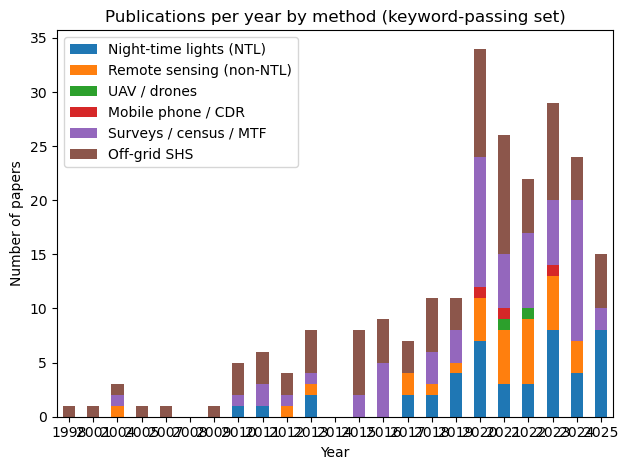

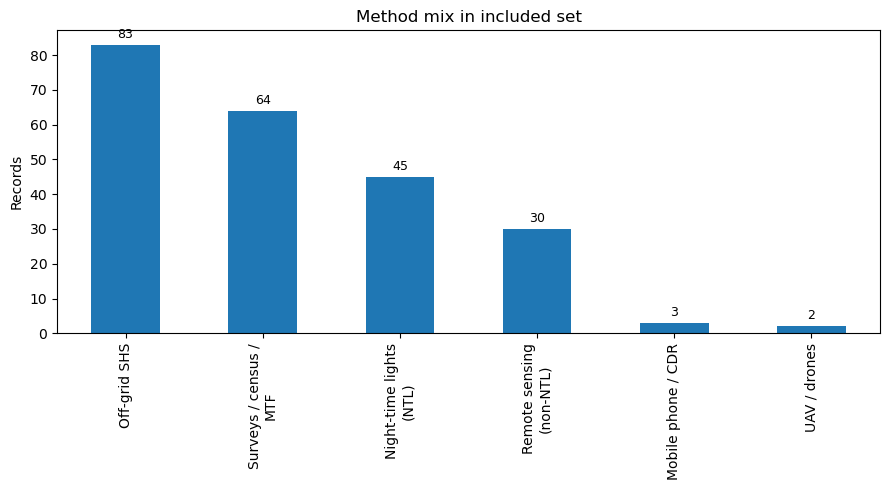

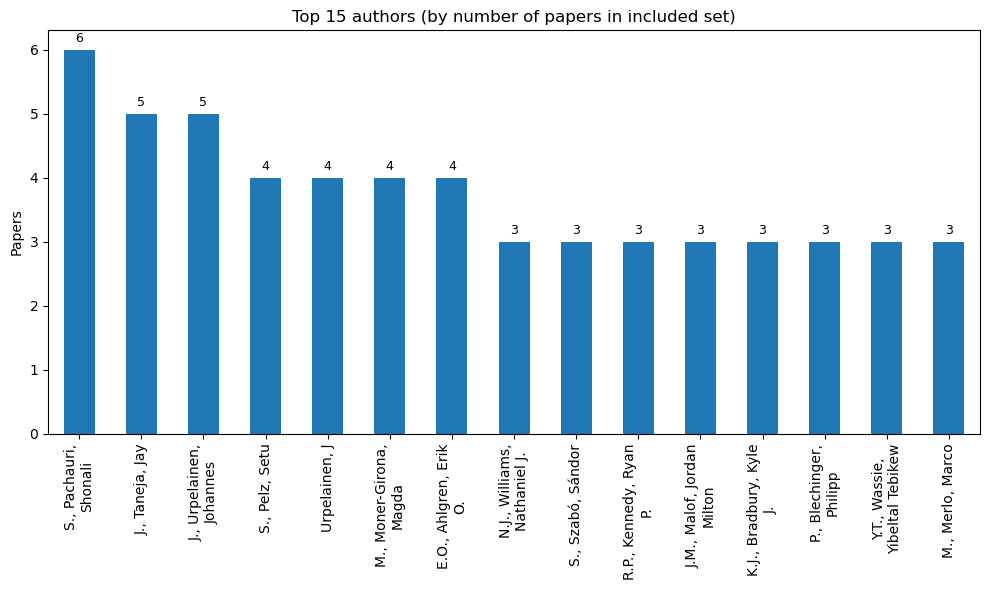

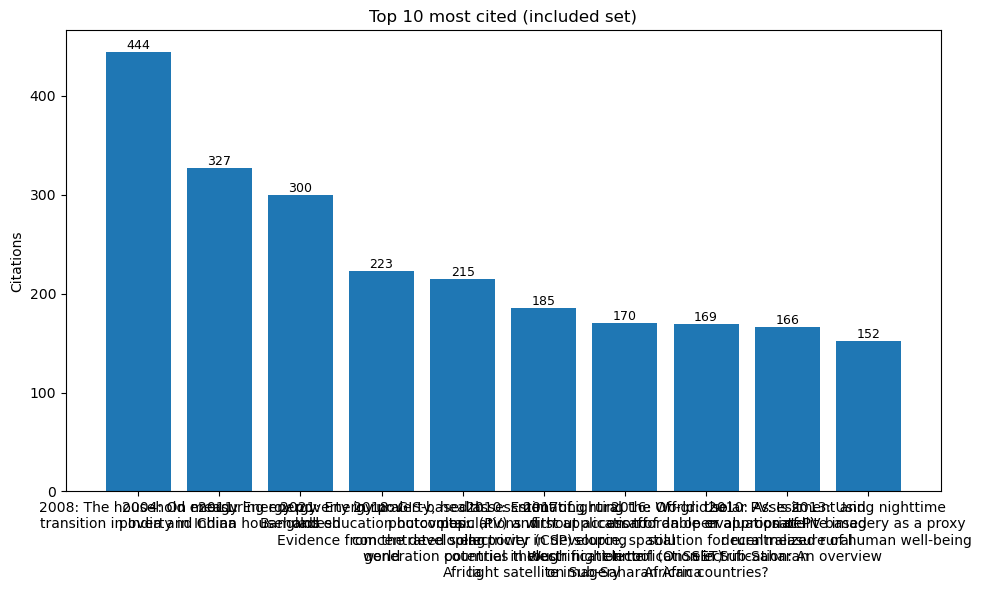

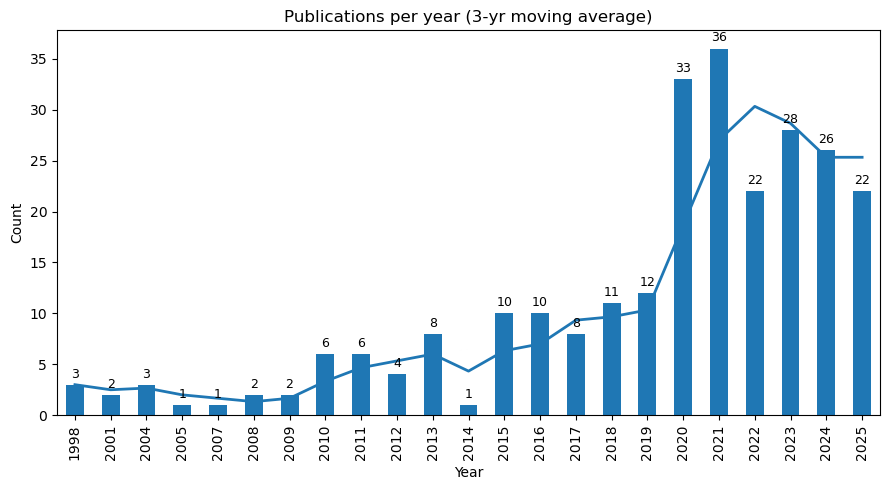

In [6]:
# ========= SUMMARIES & PLOTS (COMMUNICATION-READY) =========
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import re

PLOT_SET = df_pass.copy()   # or df_dedup for the broader set
PLOT_SET["Year"] = pd.to_numeric(PLOT_SET["Year"], errors="coerce")
PLOT_SET["Cited by"] = pd.to_numeric(PLOT_SET["Cited by"], errors="coerce").fillna(0)

def _wrap(labels, width=22):
    return ["\n".join(textwrap.wrap(str(x), width=width)) for x in labels]

def _annotate(ax):
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h) and h > 0:
            ax.annotate(f"{int(h)}", (p.get_x()+p.get_width()/2., h),
                        ha="center", va="bottom", fontsize=9, xytext=(0,3),
                        textcoords="offset points")

# --- 0) PRISMA-style counts ---
n_raw      = len(df_all)
n_dedup    = len(df_dedup)
n_dupes    = n_raw - n_dedup
n_kw_pass  = len(df_pass)
n_kw_fail  = len(df_fail)

summary_df = pd.DataFrame([
    ("Records identified (Scopus + WoS)", n_raw),
    ("Duplicates removed (DOI)", n_dupes),
    ("Records after deduplication", n_dedup),
    ("Excluded by title/keyword", n_kw_fail),
    ("Screened by abstract (keyword PASS)", n_kw_pass),
], columns=["Stage", "Count"])

# --- Detect methods from Title+Abstract+Keywords ---
_text = (PLOT_SET["Title"].fillna("") + " " +
         PLOT_SET["Abstract"].fillna("") + " " +
         PLOT_SET["Keywords"].fillna("")).str.lower()

PLOT_SET["m_ntl"]     = _text.str.contains(r"night[- ]?time light|viirs|dmsp[- ]?ols|luminosit", regex=True)
PLOT_SET["m_sat"]     = _text.str.contains(r"\b(?:remote sensing|satellite)\b", regex=True)
PLOT_SET["m_uav"]     = _text.str.contains(r"\b(?:uav|drone|unmanned (?:aerial|aircraft) vehicle|uas)\b", regex=True)
PLOT_SET["m_mobile"]  = _text.str.contains(r"\b(?:call detail record|cdr|mobile phone data)\b", regex=True)
PLOT_SET["m_survey"]  = _text.str.contains(
    r"\b(?:dhs|demographic and health survey|lsms|living standards measurement study|mics|multiple indicator cluster survey|household survey|census|national survey|multi[- ]tier framework|mtf)\b",
    regex=True
)
PLOT_SET["m_shs"]     = _text.str.contains(r"\b(?:solar home system|shs|off[- ]?grid solar|stand[- ]?alone system)\b", regex=True)

# "Remote sensing (general)" should exclude NTL so it doesn't double count
PLOT_SET["m_sat_only"] = PLOT_SET["m_sat"] & ~PLOT_SET["m_ntl"]

method_cols = ["m_ntl","m_sat_only","m_uav","m_mobile","m_survey","m_shs"]
method_labels = {
    "m_ntl": "Night‑time lights (NTL)",
    "m_sat_only": "Remote sensing (non‑NTL)",
    "m_uav": "UAV / drones",
    "m_mobile": "Mobile phone / CDR",
    "m_survey": "Surveys / census / MTF",
    "m_shs": "Off‑grid SHS"
}

# --- 1) Publications per year, stacked by method ---
year_mask = PLOT_SET["Year"].notna()
by_year_method = {lab: PLOT_SET.loc[year_mask].groupby("Year")[col].sum()
                  for col, lab in method_labels.items()}
stack_df = pd.DataFrame(by_year_method).fillna(0).sort_index()

plt.figure(figsize=(10,6))
ax = stack_df.plot(kind="bar", stacked=True)
ax.set_title("Publications per year by method (keyword‑passing set)")
ax.set_ylabel("Number of papers")
ax.set_xlabel("Year")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f"SLR_pub_year_by_method_{STAMP}.png", dpi=150)
plt.show()

# --- 2) Overall method mix (snapshot) ---
method_totals = stack_df.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(9,5))
ax = method_totals.plot(kind="bar")
ax.set_title("Method mix in included set")
ax.set_ylabel("Records")
ax.set_xticklabels(_wrap(method_totals.index, 20))
_annotate(ax)
plt.tight_layout()
plt.savefig(f"SLR_method_mix_{STAMP}.png", dpi=150)
plt.show()

# --- 3) Top authors (by paper count) ---
def split_authors(val):
    s = str(val or "").strip()
    if not s:
        return []
    # Prefer WoS/Scopus semicolon separation; if none, return full string (avoid splitting on comma inside "Last, First")
    if ";" in s:
        parts = [p.strip() for p in s.split(";") if p.strip()]
    else:
        parts = [s]  # leave as-is to avoid over-splitting
    return parts

all_authors = []
for a in PLOT_SET.get("Authors","").fillna(""):
    all_authors.extend(split_authors(a))

auth_counts = (pd.Series(all_authors).value_counts().head(15))

if len(auth_counts):
    plt.figure(figsize=(10,6))
    ax = auth_counts.plot(kind="bar")
    ax.set_title("Top 15 authors (by number of papers in included set)")
    ax.set_ylabel("Papers")
    ax.set_xticklabels(_wrap(auth_counts.index, 20))
    _annotate(ax)
    plt.tight_layout()
    plt.savefig(f"SLR_top_authors_{STAMP}.png", dpi=150)
    plt.show()

# --- 4) Top 10 most cited papers (label with year) ---
top_cited = (
    PLOT_SET.sort_values("Cited by", ascending=False)
            .loc[:, ["Title","Year","Cited by","DOI","Source title"]]
            .head(10)
            .reset_index(drop=True)
)

if len(top_cited):
    labels = [f"{row['Year']}: {row['Title']}" for _, row in top_cited.iterrows()]
    plt.figure(figsize=(10,6))
    bars = plt.bar(range(len(top_cited)), top_cited["Cited by"].values)
    plt.xticks(range(len(top_cited)), _wrap(labels, 30), rotation=0, ha="center")
    plt.title("Top 10 most cited (included set)")
    plt.ylabel("Citations")
    for i, v in enumerate(top_cited["Cited by"].values):
        plt.text(i, v, str(int(v)), ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.savefig(f"SLR_top10_cited_{STAMP}.png", dpi=150)
    plt.show()

# --- 5) Publications per year (overall trend, with 3‑yr MA) ---
pubs_year = PLOT_SET.groupby("Year").size().sort_index()
ma = pubs_year.rolling(3, min_periods=1).mean()

plt.figure(figsize=(9,5))
ax = pubs_year.plot(kind="bar")
plt.plot(range(len(ma)), ma.values, linewidth=2)
ax.set_title("Publications per year (3‑yr moving average)")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
_annotate(ax)
plt.tight_layout()
plt.savefig(f"SLR_pub_per_year_{STAMP}.png", dpi=150)
plt.show()

# --- 6) Export all summary tables to Excel ---
by_year_total = pubs_year.reset_index()
by_year_total.columns = ["Year","Records"]

method_totals_df = method_totals.reset_index()
method_totals_df.columns = ["Method","Records"]

stack_reset = stack_df.reset_index().rename(columns={"index":"Year"})

with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl", mode="a", if_sheet_exists="replace") as w:
    summary_df.to_excel(w, sheet_name="PRISMA_Summary", index=False)
    by_year_total.to_excel(w, sheet_name="Summary_ByYear", index=False)
    stack_reset.to_excel(w, sheet_name="ByYear_ByMethod", index=False)
    method_totals_df.to_excel(w, sheet_name="Method_Mix", index=False)
    auth_counts.reset_index().rename(columns={"index":"Author",0:"Papers"}).to_excel(w, sheet_name="Top_Authors", index=False)
    top_cited.to_excel(w, sheet_name="Top_Cited", index=False)
